# **This project is mainly based on using the CNN feature extraction to train any other model for example SVM for the proof of concept**
----------------------------------------------------------------------------------------------------
# **The AlexNet Architecture**
*That I will be impleminting*

![My Architecture](https://drive.google.com/uc?export=view&id=1kCj-C17MZkVij9VKQRqRcwwkZzBWchQY)
![Full Architecture](https://drive.google.com/uc?export=view&id=18FaGblJ6YJZLrdoLWZqtRAqeEQKydwY1)

# **Some libraries that will be used in the projects**

In [23]:
import numpy as np
# To get the Images
import os
import cv2
import concurrent.futures
# Importing the SVM Classifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
# Importing TensorFlow to create our CNN to extract Featuers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
# Adding the main root of the images
main = '/kaggle/input/sign-language-detection-using-images/data'
# Checking completion
print("done, importing".title())

Done, Importing


# **Getting the Data and Applying some preprocessing and visualization**

In [24]:
# Our lists directories
images = []
labels = []

# Parallel Image Loading
def process_image(image_path, folder):
    img = cv2.imread(image_path).astype('float32')
    img = cv2.resize(img, (32, 32))
    return img, folder

def process_folder(folder):
    fold = os.path.join(main, folder)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for image in os.listdir(fold):
            image_path = os.path.join(fold, image)
            futures.append(executor.submit(process_image, image_path, folder))

        for future in concurrent.futures.as_completed(futures):
            img, folder = future.result()
            images.append(img)
            labels.append(folder)

# Process each folder concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    folder_futures = [executor.submit(process_folder, folder) for folder in os.listdir(main)]
    for future in concurrent.futures.as_completed(folder_futures):
        future.result()

print("Done loading images".title())

Done Loading Images


In [25]:
# Turning them into numpy arrayes
images = np.array(images)
labels = np.array(labels)
# Printing thier shapes
print(images.shape)
print(labels.shape)
# Normalize each Image
images = images / 255
# Printing the unique labels
print(np.unique(labels))

(42000, 32, 32, 3)
(42000,)
['1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I'
 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [26]:
# Splitting Data
X_train, X_test, Y_train, Y_test = train_test_split(images,labels,test_size=0.2,random_state=42)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(33600, 8400, 33600, 8400)

# **Visualizing some Images**

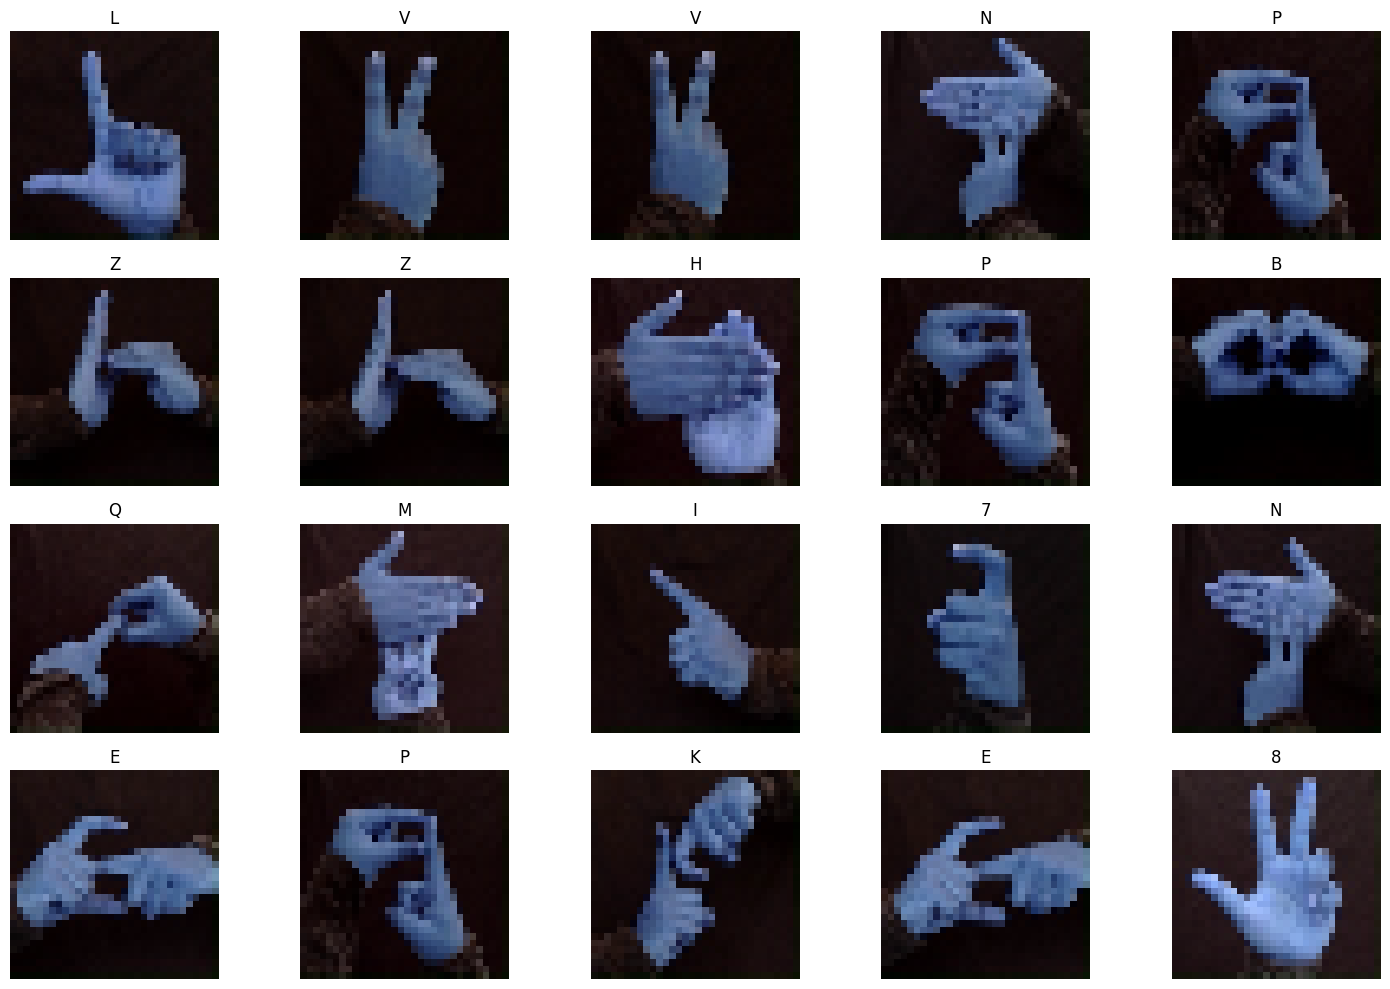

In [27]:
import matplotlib.pyplot as plt

num_images = min(20, len(images))  # Ensure we don't exceed the number of available images

# Set up the figure and axes for a grid of images
fig, axes = plt.subplots(4, 5, figsize=(15, 10))  # 4 rows and 5 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each image with its label
for i in range(num_images):
    ax = axes[i]
    ax.imshow(X_train[i])  # Display the image
    ax.axis('off')  # Hide axis
    ax.set_title(Y_train[i])  # Set the title to the label

# Turn off any unused subplots
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [28]:
# Encoding the Labels
le = LabelEncoder()
Y_train, Y_test = le.fit_transform(Y_train), le.fit_transform(Y_test)
print(len(le.classes_),le.classes_)
print(np.unique(Y_train),np.unique(Y_test))

35 ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I'
 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]


In [30]:
# Using the AlexNet Architecture to extract features from Images
featureExtractor = Sequential([
    Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),

    Flatten()
])
# This models outputs the features of the images
print("done, creating the feature extractor".title())

Done, Creating The Feature Extractor


In [31]:
# Defining the Input layer
input_layer = Input(shape=(32, 32, 3))
# Create a model that outputs the features
featureExtractorModel = Model(inputs=input_layer, outputs=featureExtractor(input_layer))

# Print the model summary
featureExtractorModel.summary()

# Print the extractor summary
featureExtractor.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 128)            │     1,257,216 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,257,216 (4.80 MB)

 Trainable params: 1,256,576 (4.79 MB)

 Non-trainable params: 640 (2.50 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 2, 2, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,257,216 (4.80 MB)

 Trainable params: 1,256,576 (4.79 MB)

 Non-trainable params: 640 (2.50 KB)

# **Extracting the Features**

In [32]:
new_X_train = featureExtractorModel.predict(X_train)
new_X_test = featureExtractorModel.predict(X_test)

print("Extracted features shape:".title(), new_X_train.shape)
print("Extracted features shape:".title(), new_X_test.shape)
print("Labels shape".title(), f"train labels shape: {Y_train.shape} & test labels shape: {Y_test.shape}")

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Extracted Features Shape: (33600, 128)
Extracted Features Shape: (8400, 128)
Labels Shape train labels shape: (33600,) & test labels shape: (8400,)


# **Observations**
* The features size is (128,).
* These features are from 32 x 32 x 3 images using a scaled alexNet Architecture.



# **Using this features to Create SVM classifier to classify our images**

In [33]:
# Starting to create the SVM Classifier
from sklearn.metrics import classification_report, accuracy_score
# The Classifier
classifier = SVC(kernel='linear', random_state=42)

# Train the classifier
classifier.fit(new_X_train, Y_train)
print("done, training".title())

Done, Training


In [34]:
# Make predictions on the test set
y_pred = classifier.predict(new_X_test)

# Evaluate performance
accuracy = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

print(f"Accuracy: {accuracy*100}%")
print("Classification Report:")
print(report)

Accuracy: 96.04761904761905%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.66      0.75       230
           1       0.97      1.00      0.98       235
           2       0.58      1.00      0.74       227
           3       1.00      0.32      0.48       239
           4       1.00      1.00      1.00       224
           5       1.00      1.00      1.00       223
           6       1.00      0.92      0.96       254
           7       1.00      1.00      1.00       224
           8       1.00      1.00      1.00       240
           9       0.90      1.00      0.95       236
          10       1.00      0.93      0.96       248
          11       1.00      1.00      1.00       252
          12       1.00      1.00      1.00       244
          13       1.00      1.00      1.00       230
          14       1.00      1.00      1.00       263
          15       0.93      1.00      0.96       240
          16       1.00      